# Creating a Kaggle Workflow

In this workbook a workflow is created with a pipeline of functions to be used in Kaggle competitions. This will be used as an example for the Kaggle Titanic competition

In [1]:
import pandas as pd
import numpy as np
import matplotlib as plt
%matplotlib inline

train = pd.read_csv('train.csv')
holdout = pd.read_csv('test.csv')

holdout.head(5)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [2]:
# %load functions.py
def process_missing(df):
    """Handle various missing values from the data set

    Usage
    ------

    holdout = process_missing(holdout)
    """
    df["Fare"] = df["Fare"].fillna(train["Fare"].mean())
    df["Embarked"] = df["Embarked"].fillna("S")
    return df

def process_age(df):
    """Process the Age column into pre-defined 'bins' 

    Usage
    ------

    train = process_age(train)
    """
    df["Age"] = df["Age"].fillna(-0.5)
    cut_points = [-1,0,5,12,18,35,60,100]
    label_names = ["Missing","Infant","Child","Teenager","Young Adult","Adult","Senior"]
    df["Age_categories"] = pd.cut(df["Age"],cut_points,labels=label_names)
    return df

def process_fare(df):
    """Process the Fare column into pre-defined 'bins' 

    Usage
    ------

    train = process_fare(train)
    """
    cut_points = [-1,12,50,100,1000]
    label_names = ["0-12","12-50","50-100","100+"]
    df["Fare_categories"] = pd.cut(df["Fare"],cut_points,labels=label_names)
    return df

def process_cabin(df):
    """Process the Cabin column into pre-defined 'bins' 

    Usage
    ------

    train process_cabin(train)
    """
    df["Cabin_type"] = df["Cabin"].str[0]
    df["Cabin_type"] = df["Cabin_type"].fillna("Unknown")
    df = df.drop('Cabin',axis=1)
    return df

def process_titles(df):
    """Extract and categorize the title from the name column 

    Usage
    ------

    train = process_titles(train)
    """
    titles = {
        "Mr" :         "Mr",
        "Mme":         "Mrs",
        "Ms":          "Mrs",
        "Mrs" :        "Mrs",
        "Master" :     "Master",
        "Mlle":        "Miss",
        "Miss" :       "Miss",
        "Capt":        "Officer",
        "Col":         "Officer",
        "Major":       "Officer",
        "Dr":          "Officer",
        "Rev":         "Officer",
        "Jonkheer":    "Royalty",
        "Don":         "Royalty",
        "Sir" :        "Royalty",
        "Countess":    "Royalty",
        "Dona":        "Royalty",
        "Lady" :       "Royalty"
    }
    extracted_titles = df["Name"].str.extract(' ([A-Za-z]+)\.',expand=False)
    df["Title"] = extracted_titles.map(titles)
    return df

def create_dummies(df,column_name):
    """Create Dummy Columns (One Hot Encoding) from a single Column

    Usage
    ------

    train = create_dummies(train,"Age")
    """
    dummies = pd.get_dummies(df[column_name],prefix=column_name)
    df = pd.concat([df,dummies],axis=1)
    return df

In [3]:
# function to clean the data

columns = ['Age_categories', 'Fare_categories', 'Title', 'Cabin_type', 'Sex']
def clean_data(dataframe):
    df = process_missing(dataframe)
    df = process_age(df)
    df = process_fare(df)
    df = process_titles(df)
    df = process_cabin(df)
    df = create_dummies(df, columns)
    return df

train_clean = clean_data(train)
holdout_clean = clean_data(holdout)

holdout_clean.head(5)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,...,Cabin_type_A,Cabin_type_B,Cabin_type_C,Cabin_type_D,Cabin_type_E,Cabin_type_F,Cabin_type_G,Cabin_type_Unknown,Sex_female,Sex_male
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,Q,...,0,0,0,0,0,0,0,1,0,1
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,S,...,0,0,0,0,0,0,0,1,1,0
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,Q,...,0,0,0,0,0,0,0,1,0,1
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,S,...,0,0,0,0,0,0,0,1,0,1
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,S,...,0,0,0,0,0,0,0,1,1,0


## Data exploration

Take a closer look at the following variables: 
- 'SibSp' is # of siblings / spouses aboard the Titanic
- 'Parch' is # of parents / children aboard the Titanic

And find out if these can be combined

In [4]:
# Show the value counts for 'SibSp'
train_clean['SibSp'].value_counts()

0    608
1    209
2     28
4     18
3     16
8      7
5      5
Name: SibSp, dtype: int64

In [5]:
# Show the value counts for 'Parch'
train_clean['Parch'].value_counts()

0    678
1    118
2     80
5      5
3      5
4      4
6      1
Name: Parch, dtype: int64

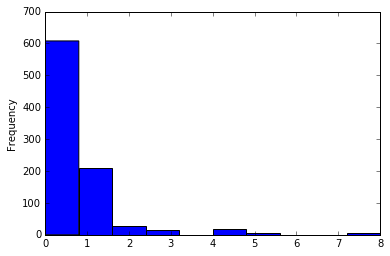

In [6]:
train_clean['SibSp'].plot.hist()

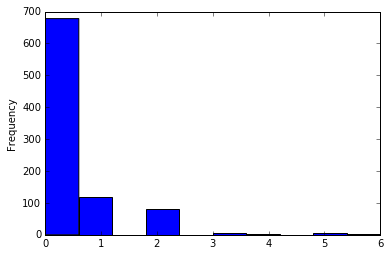

In [7]:
train_clean['Parch'].plot.hist()

In [8]:
pd.pivot_table(train_clean, values='Survived', index='SibSp')

,Survived
SibSp,
0,0.345395
1,0.535885
2,0.464286
3,0.250000
4,0.166667
5,0.000000
8,0.000000


In [9]:
pd.pivot_table(train_clean, values='Survived', index='Parch')

,Survived
Parch,
0,0.343658
1,0.550847
2,0.500000
3,0.600000
4,0.000000
5,0.200000
6,0.000000


From the pivot tables above you can see that the survival rate of persons with relatives on board is higher than people who are without relatives. It is known that women with children could leave the ship first. This will lead to an higher survival rate for this group.

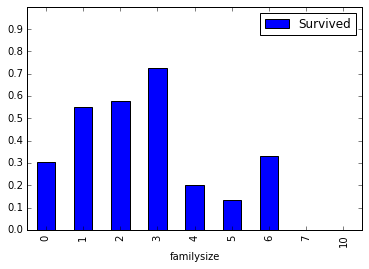

In [10]:
explore_cols = ["SibSp","Parch","Survived"]
explore = train_clean[explore_cols].copy()

explore['familysize'] = explore[["SibSp","Parch"]].sum(axis=1)
pivot = explore.pivot_table(index='familysize',values="Survived")
pivot.plot.bar(ylim=(0,1),yticks=np.arange(0,1,.1))

In [11]:
explore.head(5)

,SibSp,Parch,Survived,familysize
0,1,0,0,1
1,1,0,1,1
2,0,0,1,0
3,1,0,1,1
4,0,0,0,0


Based of this a new feature is created: was the passenger alone.
This will be a binary column containing the value:

- 1 if the passenger has zero family members onboard
- 0 if the passenger has one or more family members onboard

In [12]:
# Create the new feature 'isalone'

def isalone(df):
    if df['SibSp'] + df['Parch'] == 0:
        df['isalone']= 1
    else:
        df['isalone']= 0
    return df
        
train_clean = train_clean.apply(isalone, axis=1)
holdout_clean = holdout_clean.apply(isalone, axis=1)

In [13]:
# show the new feature column
holdout_clean[['SibSp', 'Parch', 'isalone']].head(5)

,SibSp,Parch,isalone
0,0,0,1
1,1,0,0
2,0,0,1
3,0,0,1
4,1,1,0


## Feature selection

In [14]:
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier

def select_features(df):
    df = df.select_dtypes(['number'])
    df = df.dropna(axis=1)
    all_X = df
    all_X = all_X.drop(['PassengerId', 'Survived'], axis=1)
    all_y = df['Survived']
    clf = RandomForestClassifier(random_state=1)
    selector = RFECV(clf, cv=10)
    selector.fit(all_X, all_y)
    optimized_columns = all_X.columns[selector.support_]
    return optimized_columns

selected_features = select_features(train_clean)
list(selected_features)

/dataquest/system/env/python3/lib/python3.4/site-packages/sklearn/utils/__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


['Pclass',
 'Age',
 'SibSp',
 'Parch',
 'Fare',
 'Age_categories_Missing',
 'Age_categories_Infant',
 'Age_categories_Young Adult',
 'Fare_categories_12-50',
 'Title_Miss',
 'Title_Mr',
 'Title_Mrs',
 'Cabin_type_D',
 'Cabin_type_E',
 'Cabin_type_Unknown',
 'Sex_female',
 'Sex_male',
 'isalone']

## Model selection and tuning

In [26]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

def select_model(df, features):
    all_X = df[features]
    all_y = df['Survived']
    model_info = [{"name": "LogisticRegression",
      "estimator": LogisticRegression(),
      "hyperparameters":
         {"solver": ["newton-cg", "lbfgs", "liblinear"]}
     },
      {"name": "KNeighborsClassifier",
       "estimator": KNeighborsClassifier(),
       "hyperparameters":
         {"n_neighbors": range(1,20,2),
          "weights": ["distance", "uniform"],
          "algorithm": ["ball_tree", "kd_tree", "brute"],
          "p": [1,2]}
     },
      {"name": "RandomForestClassifier",
       "estimator": RandomForestClassifier(),
       "hyperparameters":
         {"n_estimators": [4,6,9],
          "criterion": ["entropy", "gini"],
          "max_depth": [2,5,10],
          "max_features": ["log2", "sqrt"],
          "min_samples_leaf": [1,5,8],
          "min_samples_split": [2,3,5]}
     }]
    for model in model_info:
        print(model["name"])
        grid = GridSearchCV(model["estimator"], param_grid=model["hyperparameters"], cv=10)
        grid.fit(all_X, all_y)
        model["best_params"] = grid.best_params_
        model["best_score"] = grid.best_score_
        model["best_estimator"] = grid.best_estimator_
        print(grid.best_params_)
        print(grid.best_score_)
    return model_info

selected_model = select_model(train_clean, selected_features)   

LogisticRegression
{'solver': 'liblinear'}
0.8204264870931538
KNeighborsClassifier
{'weights': 'uniform', 'n_neighbors': 5, 'p': 1, 'algorithm': 'brute'}
0.7755331088664422
RandomForestClassifier
{'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'max_features': 'sqrt', 'n_estimators': 9, 'criterion': 'entropy'}
0.8417508417508418


In [28]:
# Function to create a submisson file for Kaggle

def save_submission_file(model, columns, file_name='submission.csv'):
    predictions = model.predict(holdout_clean[columns])
    holdout_ids = holdout_clean["PassengerId"]
    submission_df = {"PassengerId": holdout_ids, "Survived": predictions}
    submission = pd.DataFrame(submission_df)
    submission.to_csv(file_name, index=False)
    print('The submission file {0} is created'.format(file_name))

best_model = selected_model[2]['best_estimator']

save_submission_file(best_model, selected_features, 'submission_2.csv')

The submission file submission_2.csv is created


Next steps

Continue to explore the data and create new features, following the workflow and using the functions we created.
Read more about the titanic and this Kaggle competition to get ideas for new features.
Use some different algorithms in the select_model() function, like support vector machines, stochastic gradient descent or perceptron linear models.
Experiment with RandomizedSearchCV instead of GridSearchCV to speed up your select_features() function.